## **Synthetic Data Generation**

In [3]:
import pandas as pd
import random
import numpy as np
import string

# Function to generate synthetic data
def generate_synthetic_data(num_samples):
    data = []

    for i in range(num_samples):
        # Employee ID: Random 6-digit number
        emp_id = f"EMP{random.randint(100000, 999999)}"

        # Name: Random name (using first letter and random 3-character string)
        name = ''.join(random.choices(string.ascii_uppercase, k=1)) + ''.join(random.choices(string.ascii_lowercase, k=5))

        # Age: Random age between 22 and 60
        age = random.randint(22, 60)

        # Gender: Randomly assign "Male" or "Female"
        gender = random.choice(["Male", "Female"])

        # Experience: Random number of years between 1 and 20
        experience = random.randint(1, 20)

        # Working hours per week: Random number between 30 and 60 hours/week
        work_hours = round(random.uniform(30, 60), 1)

        # Active meeting participation: Random percentage between 50% and 100%
        meeting_participation = round(random.uniform(50, 100), 2)

        # Sentiment score: Random sentiment between -1 and 1 (Negative to Positive)
        sentiment_score = round(random.uniform(-1, 1), 2)

        # Workload: Random number between 0 and 100, representing the intensity of work
        workload = random.randint(0, 100)

        # Mistakes: Random number between 0 and 5 (mistakes made in the past week)
        mistakes = random.randint(0, 5)

        # Add employee data to list
        data.append([emp_id, name, age, gender, experience, work_hours, meeting_participation, sentiment_score, workload, mistakes])

    # Create DataFrame
    columns = ["employee_id", "name", "age", "gender", "experience", "work_hours", "meeting_participation", "sentiment_score", "workload", "mistakes"]
    df = pd.DataFrame(data, columns=columns)

    return df

# Generate synthetic data with 1000 samples
df = generate_synthetic_data(3000)

# Display first few rows of the dataset
print(df.head())

# Save the synthetic data to a CSV file if you want to export it
df.to_csv('synthetic_employee_data.csv', index=False)


  employee_id    name  age  gender  experience  work_hours  \
0   EMP782942  Abwkzq   28  Female           6        41.2   
1   EMP613059  Xrqprw   42  Female          20        52.4   
2   EMP698984  Erpdyj   29    Male          15        50.3   
3   EMP260330  Rfvpga   30  Female          18        42.9   
4   EMP849219  Ecisod   54    Male          15        32.3   

   meeting_participation  sentiment_score  workload  mistakes  
0                  57.55             0.34        85         1  
1                  94.59            -0.43        36         4  
2                  51.37             0.51        41         1  
3                  59.91            -0.25        61         0  
4                  81.37             0.49         2         4  


# Data Pre-Processing

In [4]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load your dataset
df = pd.read_csv('synthetic_employee_data.csv')

# Drop the 'name' column as it is not needed for modeling
df = df.drop(columns=['name'])

# Convert categorical variables ('gender') into numeric values
df['gender'] = df['gender'].map({'Male': 0, 'Female': 1})

# Normalize numerical features (standard scaling)
scaler = StandardScaler()
numerical_features = ['age', 'experience', 'work_hours', 'meeting_participation', 'sentiment_score', 'workload', 'mistakes']
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Exclude 'employee_id' and other non-numeric columns from the mean imputation
numeric_columns = df.select_dtypes(include=[np.number]).columns

# Fill missing values for numeric columns only
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

# Display the updated dataframe
print(df.head())


  employee_id       age  gender  experience  work_hours  \
0   EMP782942 -1.160626       1   -0.769217   -0.434528   
1   EMP613059  0.073864       1    1.648076    0.858263   
2   EMP698984 -1.072448       0    0.784757    0.615864   
3   EMP260330 -0.984270       1    1.302749   -0.238300   
4   EMP849219  1.131997       0    0.784757   -1.461834   

   meeting_participation  sentiment_score  workload  mistakes  
0              -1.191566         0.614007  1.209338 -0.923545  
1               1.392250        -0.719110 -0.469679  0.864346  
2              -1.622667         0.908332 -0.298351 -0.923545  
3              -1.026938        -0.407472  0.386962 -1.519508  
4               0.470057         0.873706 -1.634712  0.864346  


# Feature Engineering

In [5]:
# Create new features for work-life imbalance
df['work_life_imbalance'] = df['work_hours'] / (df['sentiment_score'] + 0.01)  # Small epsilon to avoid division by zero

# Create Work Intensity Feature
df['work_intensity'] = df['work_hours'] * (df['workload'] + 1)


# Adding 1 to experience to avoid division by zero
df['mistakes_per_experience_ratio'] = df['mistakes'] / (df['experience']+1)

print(df.head())

  employee_id       age  gender  experience  work_hours  \
0   EMP782942 -1.160626       1   -0.769217   -0.434528   
1   EMP613059  0.073864       1    1.648076    0.858263   
2   EMP698984 -1.072448       0    0.784757    0.615864   
3   EMP260330 -0.984270       1    1.302749   -0.238300   
4   EMP849219  1.131997       0    0.784757   -1.461834   

   meeting_participation  sentiment_score  workload  mistakes  \
0              -1.191566         0.614007  1.209338 -0.923545   
1               1.392250        -0.719110 -0.469679  0.864346   
2              -1.622667         0.908332 -0.298351 -0.923545   
3              -1.026938        -0.407472  0.386962 -1.519508   
4               0.470057         0.873706 -1.634712  0.864346   

   work_life_imbalance  work_intensity  mistakes_per_experience_ratio  
0            -0.696350       -0.960018                      -4.001795  
1            -1.210338        0.455154                       0.326405  
2             0.670634        0.432121

# Model Generation - One Class SVM Model

In [8]:
from sklearn.svm import OneClassSVM
import matplotlib.pyplot as plt

# Extract relevant features for modeling (exclude employee_id, gender as they are non-numeric after encoding)
features = df[['age', 'experience', 'work_hours', 'meeting_participation', 'sentiment_score',
               'workload', 'mistakes', 'work_life_imbalance', 'work_intensity','mistakes_per_experience_ratio']]

# Initialize the One-Class SVM model
ocsvm = OneClassSVM(nu=0.1, kernel='rbf', gamma='scale')

# Train the model on the scaled data (already done previously with StandardScaler)
ocsvm.fit(features)

# Step 3: Make Predictions
# Predict whether each employee is an anomaly (-1) or not (1)
df['burnout_risk'] = ocsvm.predict(features)

# Step 4: Analysis
# Employees predicted as anomalies will have burnout_risk == -1
burnout_risk_employees = df[df['burnout_risk'] == -1]

# Count the total number of persons with burnout risk (predicted as -1) and without burnout risk (predicted as +1)
burnout_count = df['burnout_risk'].value_counts()

# Print the results
print("Total number of employees with burnout risk (predicted as -1):", burnout_count.get(-1, 0))
print("Total number of employees without burnout risk (predicted as +1):", burnout_count.get(1, 0))


Total number of employees with burnout risk (predicted as -1): 299
Total number of employees without burnout risk (predicted as +1): 2701


In [9]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Assuming 'df' is your dataframe and 'burnout_risk' is the target variable

# Step 1: Exclude non-numeric columns (e.g., 'employee_id', 'name', etc.)
# Select only numeric columns
numeric_columns = df.select_dtypes(include=[np.number]).columns

# Step 2: Define features (X) and target (y)
X = df[numeric_columns].drop(columns=['burnout_risk'], errors='ignore')  # Exclude target column
y = df['burnout_risk']  # Target variable

# Step 3: Train a RandomForest model to get feature importances
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Step 4: Get feature importances and sort them
feature_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

# Step 5: Display top important features
print(feature_importances)


work_life_imbalance              0.374179
mistakes_per_experience_ratio    0.345756
experience                       0.089515
sentiment_score                  0.081112
mistakes                         0.028453
work_hours                       0.026928
work_intensity                   0.018002
meeting_participation            0.013365
workload                         0.010653
age                              0.010449
gender                           0.001587
dtype: float64


In [12]:
top_features = feature_importances.index[:5]  # Based on feature importance
print("Top Features:", top_features)


Top Features: Index(['work_life_imbalance', 'mistakes_per_experience_ratio', 'experience',
       'sentiment_score', 'mistakes'],
      dtype='object')


In [14]:
# Assuming 'df' is your dataframe, and 'feature_importances' is the series from RandomForestClassifier

# Step 1: Extract the top 5 important features
top_features = feature_importances.index[:5]
print("Top Features:", top_features)

# Step 2: Prepare the data with the top 5 features
X_top_features = df[top_features]

# Step 3: Preprocessing the data - Standardizing features (One-Class SVM works better with standardized data)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_top_features)

# Step 4: Train the One-Class SVM model
ocsvm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.05)  # Adjust 'nu' as needed
ocsvm.fit(X_scaled)

# Step 5: Predict anomalies
y_pred = ocsvm.predict(X_scaled)

# The model will predict 1 for normal points and -1 for anomalies
# Convert -1 to 0 for better interpretation (optional)
# y_pred = [0 if x == -1 else 1 for x in y_pred]

# Step 6: Add predictions to the dataframe for analysis
df['ocsvm_prediction'] = y_pred

# Print the first few rows to inspect the predictions
print(df[['ocsvm_prediction'] + list(top_features)].head())

# Print Burnout count
burnout_counts = df['burnout_risk'].value_counts()
print("\nCount of Normal and At-Risk Predictions:")
print(burnout_counts)


Top Features: Index(['work_life_imbalance', 'mistakes_per_experience_ratio', 'experience',
       'sentiment_score', 'mistakes'],
      dtype='object')
   ocsvm_prediction  work_life_imbalance  mistakes_per_experience_ratio  \
0                 1            -0.696350                      -4.001795   
1                 1            -1.210338                       0.326405   
2                 1             0.670634                      -0.517462   
3                 1             0.599540                      -0.659867   
4                 1            -1.654209                       0.484293   

   experience  sentiment_score  mistakes  
0   -0.769217         0.614007 -0.923545  
1    1.648076        -0.719110  0.864346  
2    0.784757         0.908332 -0.923545  
3    1.302749        -0.407472 -1.519508  
4    0.784757         0.873706  0.864346  

Count of Normal and At-Risk Predictions:
burnout_risk
 1    2701
-1     299
Name: count, dtype: int64


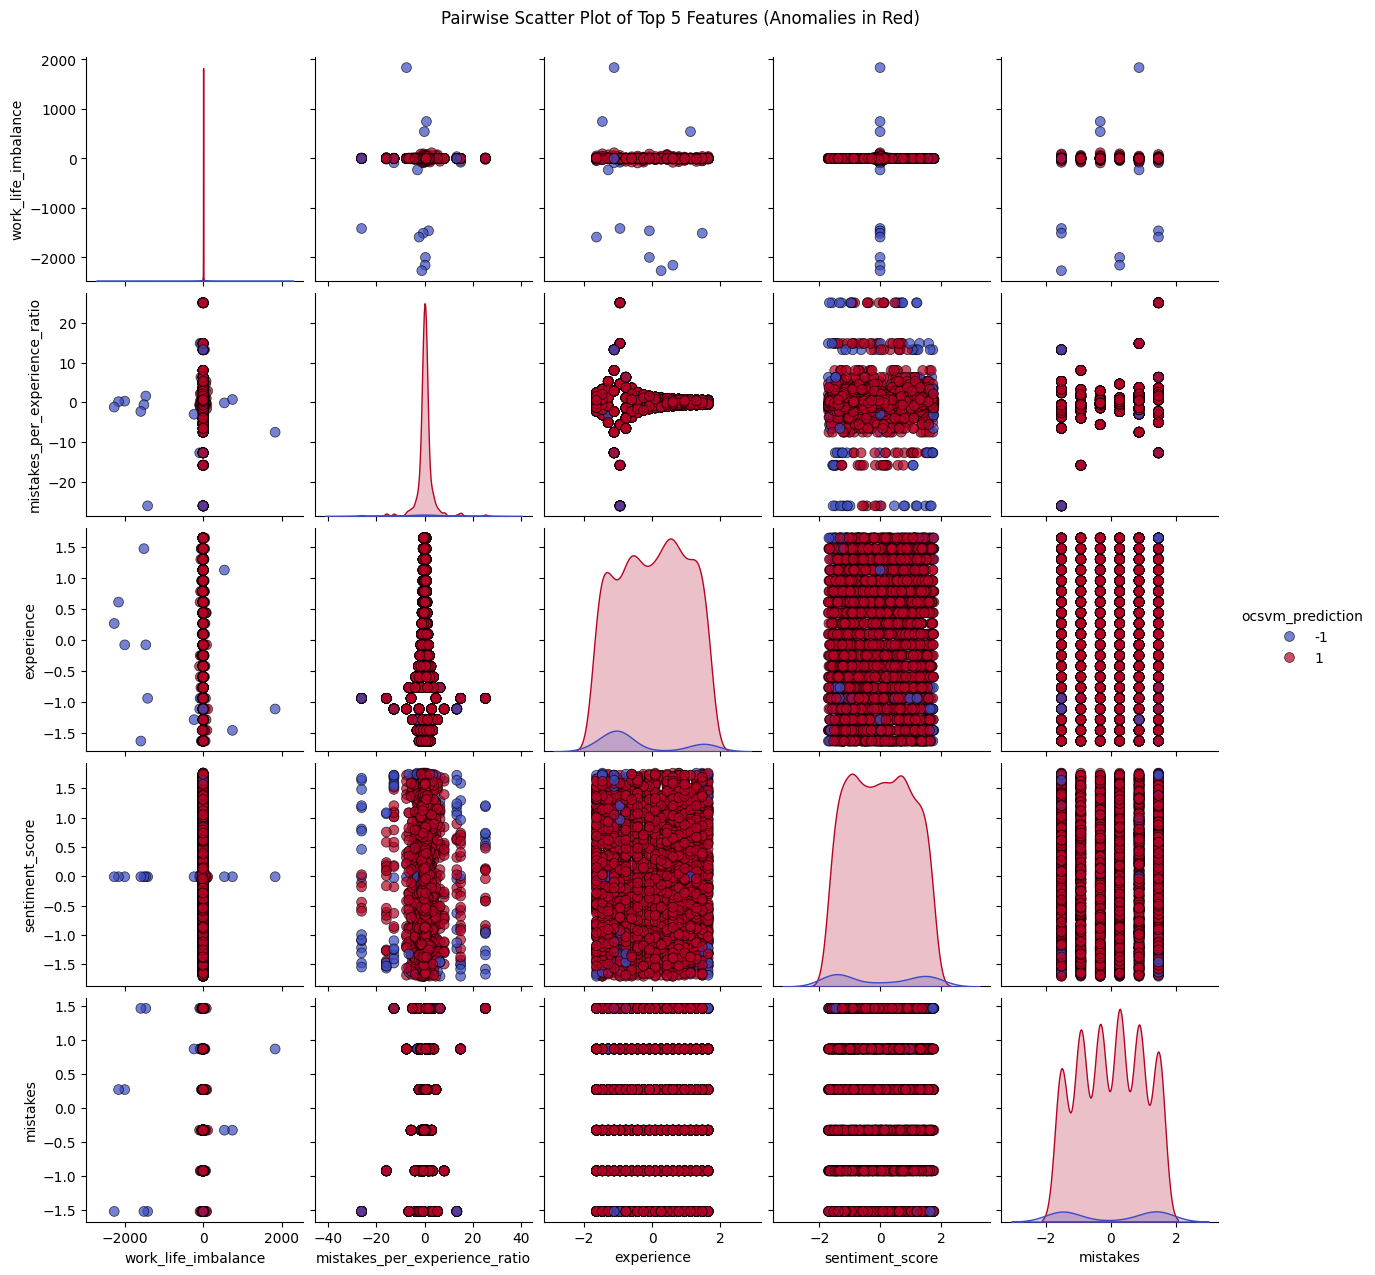

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'df' contains the feature columns and 'ocsvm_prediction' is the anomaly prediction column

# Step 1: Prepare the data with the top 5 features and their predictions
top_features = feature_importances.index[:5]
X_top_features = df[top_features]
df['ocsvm_prediction'] = y_pred  # Anomaly predictions: 1 for normal, 0 for anomalies

# Step 2: Create Pairwise Scatter Plots to visualize the anomalies
sns.pairplot(df, vars=top_features, hue='ocsvm_prediction', palette='coolwarm', plot_kws={'edgecolors': 'k', 's': 50, 'alpha': 0.7})
plt.suptitle("Pairwise Scatter Plot of Top 5 Features (Anomalies in Red)", y=1.02)
plt.show()


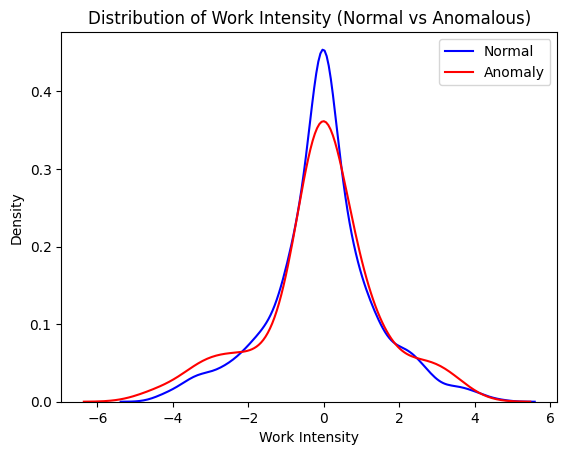

In [16]:
import seaborn as sns

# Plot the distribution of a top feature (example: 'work_intensity')
sns.kdeplot(df[df['ocsvm_prediction'] == 1]['work_intensity'], label='Normal', color='blue')
sns.kdeplot(df[df['ocsvm_prediction'] == -1]['work_intensity'], label='Anomaly', color='red')
plt.title('Distribution of Work Intensity (Normal vs Anomalous)')
plt.xlabel('Work Intensity')
plt.ylabel('Density')
plt.legend()
plt.show()

In [21]:
user_input = {}

for feature in top_features:
    user_input[feature] = float(input(f"Enter value for {feature}: "))

Enter value for work_life_imbalance: 60.20
Enter value for mistakes_per_experience_ratio: 0.105
Enter value for experience: 18
Enter value for sentiment_score: 0.97
Enter value for mistakes: 2


In [24]:
# Create a NumPy array for the new data point
new_data_point = np.array([[user_input[feature] for feature in top_features]])

# Scale the new data point (using the same scaler that was used during training)
new_data_point_scaled = scaler.fit_transform(new_data_point)

In [30]:
prediction = ocsvm.predict(new_data_point_scaled)

# Output the prediction result
if prediction == 1:
    print("Your Employee is Good")
else:
    print("Taking a break isn't necessity!!!\nHealthy Employyes are Happy Employees")

Your Employee is Good
